In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_boston

house = load_boston()
house.keys()
house_df = pd.DataFrame(house.data, columns = house.feature_names)
house_df.head()
house_df['PRICE'] = house.target
house_df.to_pickle('dataset/house_df.pkl')
house_df = pd.read_pickle('dataset/house_df.pkl')
house_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = house_df['PRICE']
X_data = house_df.drop('PRICE',axis=1,inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=1)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print('MSE: {0:.4f}, RMSE: {1:.4f}, R2 score: {2:.4f}'.format(mse,rmse,r2))
print('절편 값: ',lr.intercept_)
print('회귀 계수값: ', np.round(lr.coef_, 1))

MSE: 19.8313, RMSE: 4.4532, R2 score: 0.7836
절편 값:  46.39649387182395
회귀 계수값:  [ -0.1   0.1   0.1   2.4 -21.5   2.8   0.   -1.5   0.3  -0.   -1.    0.
  -0.6]


<AxesSubplot:>

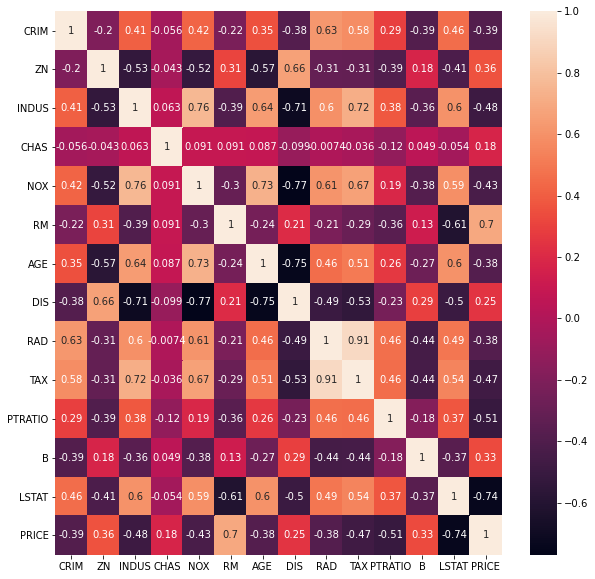

In [5]:
plt.figure(figsize=(10,10))
sns.heatmap(house_df.corr(), annot=True)

<AxesSubplot:xlabel='PRICE', ylabel='Density'>

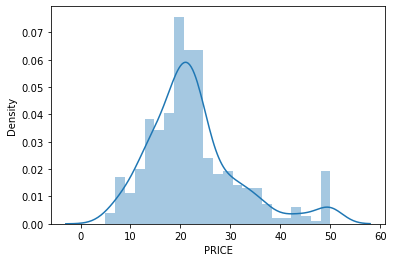

In [7]:
import warnings
warnings.filterwarnings('ignore')
sns.distplot(house_df.PRICE)

<AxesSubplot:xlabel='PRICE', ylabel='Density'>

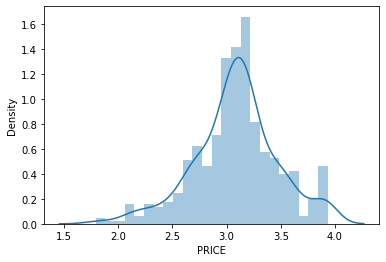

In [10]:
# 로그 변환을 하는 이유는
# 원본 데이터가 정규성에서 다소 벗어난 모습을 보이고 있기 때문에
# 이를 완화하고자 로그 변환을 하는 것이다.
# Standard Scaler, Min-Max Scaler 등보다 로그변환이 정규성 회복에 효과적이다.
# 로그변환 데이터로 학습시킨 후 MSE, RMSE 평가를 할 때는
# 원본 데이터에 대해 평가하는 것이기 때문에 로그변환된 것을 기존의 데이터 형태로 환원시키는 것이다.
# MSLE, RMSLE 등을 구할 경우는 로그변환된 데이터를 환원하지 않고 그대로 평가하면 된다.
sns.distplot(np.log1p(house_df.PRICE))

<AxesSubplot:>

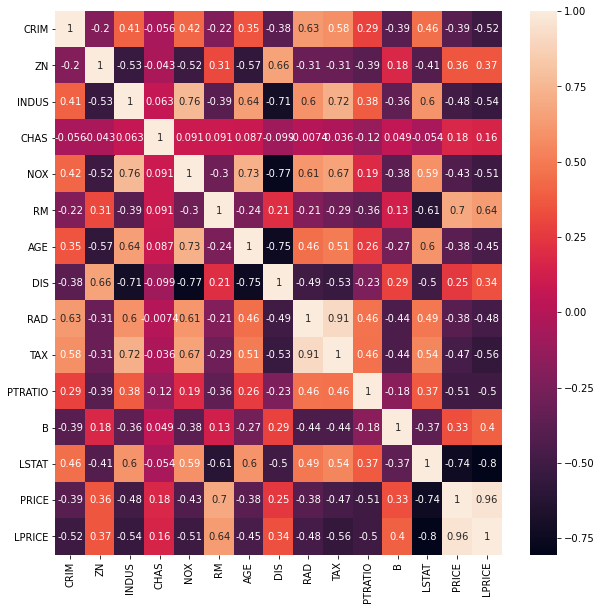

In [12]:
house_df['LPRICE'] = np.log1p(house_df.PRICE)
plt.figure(figsize=(10,10))
sns.heatmap(house_df.corr(), annot=True)

In [9]:
# 종속변수 로그 변환 및 독립변수 선택

X=house_df[['RM','INDUS','NOX','PTRATIO','LSTAT','RAD']]
y=house_df['PRICE']

y_log = np.log1p(house_df['PRICE'])

X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.3, random_state=1)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# 로그 변환했던 데이터를 다시 원본 범위로 환원
y_exp = np.expm1(y_test)
y_pexp = np.expm1(y_pred)

mse = mean_squared_error(y_exp, y_pexp)
rmse = np.sqrt(mse)
r2 = r2_score(y_exp, y_pexp)
print('MSE: {0:.4f}, RMSLE: {1:.4f}, R2 score: {2:.4f}'.format(mse,rmse,r2))


msle = mean_squared_error(y_test, y_pred)
rmsle = np.sqrt(msle)
log_r2 = r2_score(y_test, y_pred)
print('MSLE: {0:.4f}, RMSLE: {1:.4f}, R2 score: {2:.4f}'.format(msle,rmsle,log_r2))


print('절편 값: ',lr.intercept_)
print('회귀 계수값: ', np.round(lr.coef_, 1))

MSE: 26.2856, RMSLE: 5.1270, R2 score: 0.7132
MSLE: 0.0404, RMSLE: 0.2010, R2 score: 0.7398
절편 값:  3.95274293214216
회귀 계수값:  [ 0.1  0.  -0.5 -0.  -0.   0. ]


In [17]:
# 교차 검증
from sklearn.model_selection import cross_val_score

y_target = house_df['PRICE']
X_data = house_df.drop(['PRICE','LPRICE'], axis=1)

lr = LinearRegression()

# 회귀평가에서 GCV나 cross_val_score를 사용할 때 주의해야할 점
# 정확도는 높을수록, 오차는 작을수록 좋다. 오차의 부정적인 면을 부각하고자 -를 붙여 준다?
#                                                               마이너스 부호 처리를 해준다?
#                            mean_squared_error에다가 -처리해줬다고 앞에 neg를 붙이는 것이다.
neg_mse_scores = cross_val_score(lr, X_data, y_target, scoring='neg_mean_squared_error', cv = 5)
# 위에서 -를 해 줬으니, 여기선 -를 한번 더 곱해서 +로 원상복구 시켜야 한다.
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5 folds의 개별 Negative MSE scores:', np.round(neg_mse_scores,2))
print('5 folds의 개별 RMSE scores:', np.round(rmse_scores,2))
print('5 folds의 평균 RMSE:{:.4f}'.format(avg_rmse))

5 folds의 개별 Negative MSE scores: [-12.46 -26.05 -33.07 -80.76 -33.31]
5 folds의 개별 RMSE scores: [3.53 5.1  5.75 8.99 5.77]
5 folds의 평균 RMSE:5.8287


### 규제 선형 모델 - 릿지, 라쏘, 엘라스틱넷

- 회귀 모델은 적절히 데이터에 적합하면서도 회귀 계수가 기하급수적으로 커지는 것을 제어할 필요가 있음
- 선형 모형의 비용함수는 RSS(실제 값과 예측 값의 차이)를 최소화하는 것만 고려한 결과 테스트 데이터 세트 예측 성능 저하 초래
- RSS 최소화 방법과 과적합을 방지하기 위해 회귀 계수 값이 커지지 않도록 하는 방법이 서로 균형을 이루게 해야 한다. (최적모델을 위한 Cost 함수 구성 요소 = 학습 데이터 잔차 오류 최소화 + 회귀 계수 크기 제어)
- 회귀 계수 값의 크기를 조절하기 위하여 비용 함수에 알파 값으로 패널티를 부여해 과적합을 개선하는 방식을 규제라고 한다.
- alpha값을 크게 하면 비용 함수는 회귀 계수(W)의 값을 작게 해 과적합을 개선할 수 있으며 alpha값을 작게 하면 회귀 계수 W의 값이 커져도 어느 정도 상쇄가 가능하므로 학습데이터 적합을 더 개선
- 비용함수에 alpha값으로 패널티를 부여해 회귀 계수 값의 크기를 감소시켜 과적합을 개선하는 방식을 규제하고 한다.
- 규제는 크게 L2 방식과 L1 방식으로 구분되며, 전자를 적용한 회귀를 릿지, 후자를 적용한 것이 라쏘임.
- L2는 W의 제곱에 패널티를 부여하며 L1은 W의 절댓값에 패널티 부여
- 엘라스틱넷 회귀는 L2 규제와 L1 규제를 결합한 회귀

In [16]:
# 릿지 회귀
from sklearn.linear_model import Ridge

y_target = house_df['PRICE']
X_data = house_df.drop(['PRICE','LPRICE'], axis=1)
ridge = Ridge(alpha=10)

neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring='neg_mean_squared_error', cv = 5)

rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5 folds의 개별 Negative MSE scores:', np.round(neg_mse_scores,2))
print('5 folds의 개별 RMSE scores:', np.round(rmse_scores,2))
print('5 folds의 평균 RMSE:{:.4f}'.format(avg_rmse))

5 folds의 개별 Negative MSE scores: [-11.42 -24.29 -28.14 -74.6  -28.52]
5 folds의 개별 RMSE scores: [3.38 4.93 5.31 8.64 5.34]
5 folds의 평균 RMSE:5.5182


In [20]:
alphas = [0,0.1,1,10,100]

y_target = house_df['PRICE']
X_data = house_df.drop(['PRICE','LPRICE'], axis=1)

for i in alphas:
    ridge = Ridge(alpha=i)

    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring='neg_mean_squared_error', cv = 5)

    rmse_scores = np.sqrt(-1*neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    
    print('alpha = ', i)
    print('5 folds의 평균 RMSE:{:.4f}'.format(avg_rmse))

alpha =  0
5 folds의 평균 RMSE:5.8287
alpha =  0.1
5 folds의 평균 RMSE:5.7885
alpha =  1
5 folds의 평균 RMSE:5.6526
alpha =  10
5 folds의 평균 RMSE:5.5182
alpha =  100
5 folds의 평균 RMSE:5.3296


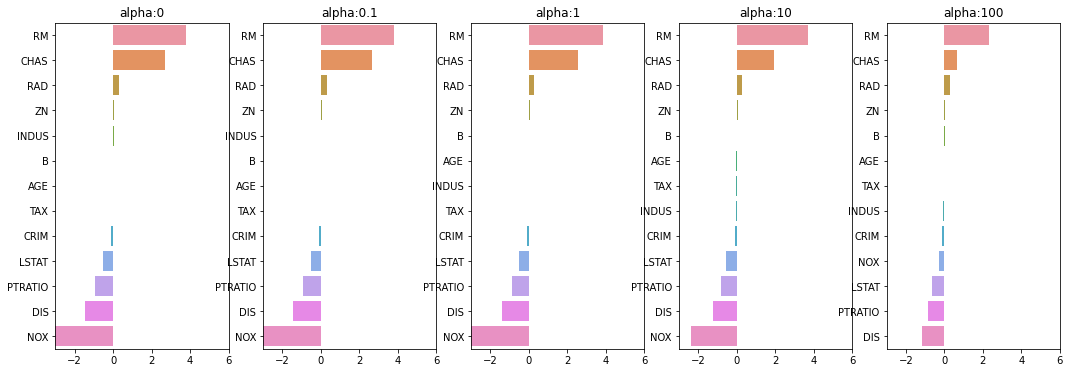

In [21]:
fig, axs = plt.subplots(figsize=(18,6), nrows = 1, ncols = 5)
coeff_df = pd.DataFrame()

for pos, alpha in enumerate(alphas):
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_data, y_target)
    
    coeff = pd.Series(data = ridge.coef_, index = X_data.columns)
    colname = 'alpha:' + str(alpha)
    coeff_df[colname] = coeff
    
    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3, 6)
    sns.barplot(x = coeff.values, y = coeff.index, ax = axs[pos])
    
# alpha값이 커질수록 회귀계수들이 줄어드는 것을 시각화한 것.

In [29]:
ridge_alphas = [0,0.1,1,10,100]
sort_column = 'alpha:' + str(ridge_alphas[0])
coeff_df.sort_values(by = sort_column, ascending = False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


In [22]:
# 모델별 alpha별 교차 검증 및 회귀계수 출력

from sklearn.linear_model import Lasso, ElasticNet
def get_linear_reg_eval(model_name, params=None, X_data_n = None, y_target_n = None, verbose = True):
    coeff_df = pd.DataFrame()
    if verbose:print('###### ', model_name, '######')
    for param in params:
        if model_name == 'Ridge': model = Ridge(alpha = param)
        elif model_name == 'Lasso': model = Lasso(alpha = param)
        elif model_name == 'ElasticNet': model = ElasticNet(alpha = param, l1_ratio = 0.7)
            
        neg_mse_scores = cross_val_score(model, X_data_n, y_target_n,\
                                         scoring='neg_mean_squared_error', cv=5)
        
        avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
        print('alpla {}일 때 5 Folds 세트의 평균 RMSE:{:.4f}'.format(param, avg_rmse))
        model.fit(X_data, y_target)
        coeff = pd.Series(data = model.coef_, index = X_data.columns)
        colname = 'alpha:' + str(param)
        coeff_df[colname] = coeff
        
    return coeff_df

In [26]:
# 라쏘 회귀

# 릿지는 0이 나오지 않는데, 라쏘는 0이 나올 수 있다.

lasso_alphas = [0.07, 0.1, 0.5, 1.3]
coeff_lasso_df = get_linear_reg_eval('Lasso', params = lasso_alphas,\
                                     X_data_n = X_data, y_target_n = y_target)

coeff_lasso_df

######  Lasso ######
alpla 0.07일 때 5 Folds 세트의 평균 RMSE:5.6123
alpla 0.1일 때 5 Folds 세트의 평균 RMSE:5.6151
alpla 0.5일 때 5 Folds 세트의 평균 RMSE:5.6691
alpla 1.3일 때 5 Folds 세트의 평균 RMSE:5.8451


,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1.3
CRIM,-0.098193,-0.097894,-0.083289,-0.051638
ZN,0.049059,0.049211,0.049544,0.048850
INDUS,-0.042120,-0.036619,-0.005253,-0.000000
CHAS,1.434343,0.955190,0.000000,0.000000
NOX,-0.000000,-0.000000,-0.000000,-0.000000
RM,3.789725,3.703202,2.498212,0.018113
AGE,-0.011706,-0.010037,0.003604,0.031350
DIS,-1.176583,-1.160538,-0.936605,-0.511309
RAD,0.270936,0.274707,0.277451,0.255433
TAX,-0.014290,-0.014570,-0.015442,-0.014981


In [25]:
# 엘라스틱넷 회귀
elastic_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df = get_linear_reg_eval('ElasticNet', params = elastic_alphas,\
                                     X_data_n = X_data, y_target_n = y_target)

coeff_elastic_df

######  ElasticNet ######
alpla 0.07일 때 5 Folds 세트의 평균 RMSE:5.5417
alpla 0.1일 때 5 Folds 세트의 평균 RMSE:5.5259
alpla 0.5일 때 5 Folds 세트의 평균 RMSE:5.4667
alpla 1일 때 5 Folds 세트의 평균 RMSE:5.5969
alpla 3일 때 5 Folds 세트의 평균 RMSE:6.0681


,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000
RM,3.574162,3.414154,1.918419,0.938789,0.000000
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
DIS,-1.189438,-1.173647,-0.975902,-0.725174,-0.031208
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417


In [31]:
# 선형 회귀 모형을 위한 데이터 변환
#                                                              단항식을 다항식으로 바꿔주는 객체
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
def get_scaled_data(method = None, p_degree = None, input_data = None):
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == 'MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data = np.log1p(input_data)
    else:
        scaled_data = input_data
        
    if p_degree != None:
        scaled_data = PolynomialFeatures(degree = p_degree, include_bias = False).fit_transform(scaled_data)
    
    return scaled_data

In [33]:
alphas = [0.1, 1, 10, 100]
scale_methods = [(None, None), ('Standard', None), ('Standard', 2),
                ('MinMax', None), ('MinMax', 2), ('Log', None)]

for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method = scale_method[0], p_degree = scale_method[1],\
                                    input_data = X_data)
    print('\n## 변환 유형:{0}, Polynomial Degree:{1}'.format(scale_method[0], scale_method[1]))
    get_linear_reg_eval('Ridge', params = alphas, X_data_n = X_data_scaled, y_target_n = y_target,\
                        verbose = False)


## 변환 유형:None, Polynomial Degree:None
alpla 0.1일 때 5 Folds 세트의 평균 RMSE:5.7885
alpla 1일 때 5 Folds 세트의 평균 RMSE:5.6526
alpla 10일 때 5 Folds 세트의 평균 RMSE:5.5182
alpla 100일 때 5 Folds 세트의 평균 RMSE:5.3296

## 변환 유형:Standard, Polynomial Degree:None
alpla 0.1일 때 5 Folds 세트의 평균 RMSE:5.8260
alpla 1일 때 5 Folds 세트의 평균 RMSE:5.8029
alpla 10일 때 5 Folds 세트의 평균 RMSE:5.6368
alpla 100일 때 5 Folds 세트의 평균 RMSE:5.4214

## 변환 유형:Standard, Polynomial Degree:2
alpla 0.1일 때 5 Folds 세트의 평균 RMSE:8.8272
alpla 1일 때 5 Folds 세트의 평균 RMSE:6.8713
alpla 10일 때 5 Folds 세트의 평균 RMSE:5.4849
alpla 100일 때 5 Folds 세트의 평균 RMSE:4.6344

## 변환 유형:MinMax, Polynomial Degree:None
alpla 0.1일 때 5 Folds 세트의 평균 RMSE:5.7636
alpla 1일 때 5 Folds 세트의 평균 RMSE:5.4650
alpla 10일 때 5 Folds 세트의 평균 RMSE:5.7542
alpla 100일 때 5 Folds 세트의 평균 RMSE:7.6349

## 변환 유형:MinMax, Polynomial Degree:2
alpla 0.1일 때 5 Folds 세트의 평균 RMSE:5.2976
alpla 1일 때 5 Folds 세트의 평균 RMSE:4.3227
alpla 10일 때 5 Folds 세트의 평균 RMSE:5.1852
alpla 100일 때 5 Folds 세트의 평균 RMSE:6.5379

## 변환 유형:Log,